In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ridge_regression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

In [83]:
df1 = pd.read_csv('../../data/cleaned/bigger_wildfire_weather_extra.csv')
df2 = pd.read_csv('../../data/processed/precipitation_sum_180d.csv')
df2.rename(columns = {'ID': 'id'}, inplace = True)
df = pd.merge(df1, df2, on = 'id')
df.head()

,id,x,y,containmentdatetime,controldatetime,dailyacres,discoveryacres,firecause,firediscoverydatetime,incidenttypecategory,...,temp_2m_mean,rain_sum,dew_frost_point_2m,wet_bulb_temp_2m,relative_humidity,clear_sky_photosynthetically_active_radiation,all_sky_photosynthetically_active_radiation,all_sky_surface_uv_index,sum_rain,sum_snow
0,1,-115.748812,40.617506,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,5985.90,5.0,Natural,2020-07-19 23:00:00+00:00,WF,...,23.396304,12.62,3.02,13.91,27.31,155.74,135.50,2.55,84.37,1.32
1,5,-113.751212,35.515265,2020-10-17 21:59:59+00:00,2020-10-19 15:00:00+00:00,135.00,1.0,Human,2020-10-15 18:17:00+00:00,WF,...,21.522000,0.00,-6.50,8.11,13.62,97.43,97.50,1.37,10.54,0.00
2,10,-120.073602,39.769989,2020-06-24 19:02:00+00:00,2020-06-25 16:05:59+00:00,132.00,15.0,Natural,2020-06-24 00:17:59+00:00,WF,...,25.600000,0.16,7.16,16.69,33.44,160.50,160.38,2.82,68.55,0.66
3,12,-120.772613,39.361785,2021-01-20 03:29:00+00:00,2021-01-21 00:57:00+00:00,1.88,1.0,Human,2021-01-19 19:40:00+00:00,WF,...,1.500000,0.00,-9.35,-4.95,51.38,59.11,57.91,0.37,700.02,14.17
4,15,-122.974081,41.825916,2020-07-23 17:00:00+00:00,2020-07-26 15:00:00+00:00,13.00,0.1,Human,2020-07-22 19:09:59+00:00,WF,...,21.058000,1.61,8.76,15.53,48.62,142.94,114.08,1.96,295.31,0.66


In [84]:
df1.shape

(2109, 43)

In [85]:
df.shape

(2053, 45)

In [86]:
df['firediscoverydatetime'] = pd.to_datetime(df['firediscoverydatetime'])
df['controldatetime'] = pd.to_datetime(df['controldatetime'])
df['containmentdatetime'] = pd.to_datetime(df['containmentdatetime'])

In [87]:
for i in df.columns:
    print(i)

id
x
y
containmentdatetime
controldatetime
dailyacres
discoveryacres
firecause
firediscoverydatetime
incidenttypecategory
incidenttypekind
initiallatitude
initiallongitude
irwinid
localincidentidentifier
poocounty
poodispatchcenterid
poofips
poostate
uniquefireidentifier
temp_2m
temp_2m_max
humidity
rain
wind_speed_2m
wind_speed_2m_max
wind_speed_10m
wind_speed_10m_max
surface_soil_wetness_5cm_below
surface_soil_wetness_to_bedrock
wind_speed_2m_mean
wind_speed_2m_max_mean
wind_speed_10m_mean
wind_speed_10m_max_mean
humidity_mean
temp_2m_mean
rain_sum
dew_frost_point_2m
wet_bulb_temp_2m
relative_humidity
clear_sky_photosynthetically_active_radiation
all_sky_photosynthetically_active_radiation
all_sky_surface_uv_index
sum_rain
sum_snow


---
######
### Investigating Correlation Between the Features and Target (DailyAcres) for Large Fires (>1 Acre)
######
___

In [88]:
cols = ['dailyacres', 'discoveryacres', 'temp_2m', 'temp_2m_max', 'humidity', 'rain', 'wind_speed_2m', 'wind_speed_2m_max', 'wind_speed_10m', 
        'wind_speed_10m_max', 'surface_soil_wetness_5cm_below', 'surface_soil_wetness_to_bedrock', 'wind_speed_2m_mean', 'wind_speed_2m_max_mean', 
        'wind_speed_10m_mean', 'wind_speed_10m_max_mean', 'humidity_mean', 'temp_2m_mean', 'rain_sum', 'dew_frost_point_2m', 'wet_bulb_temp_2m', 
        'relative_humidity', 'clear_sky_photosynthetically_active_radiation', 'all_sky_photosynthetically_active_radiation', 'all_sky_surface_uv_index',
        'sum_rain', 'sum_snow']

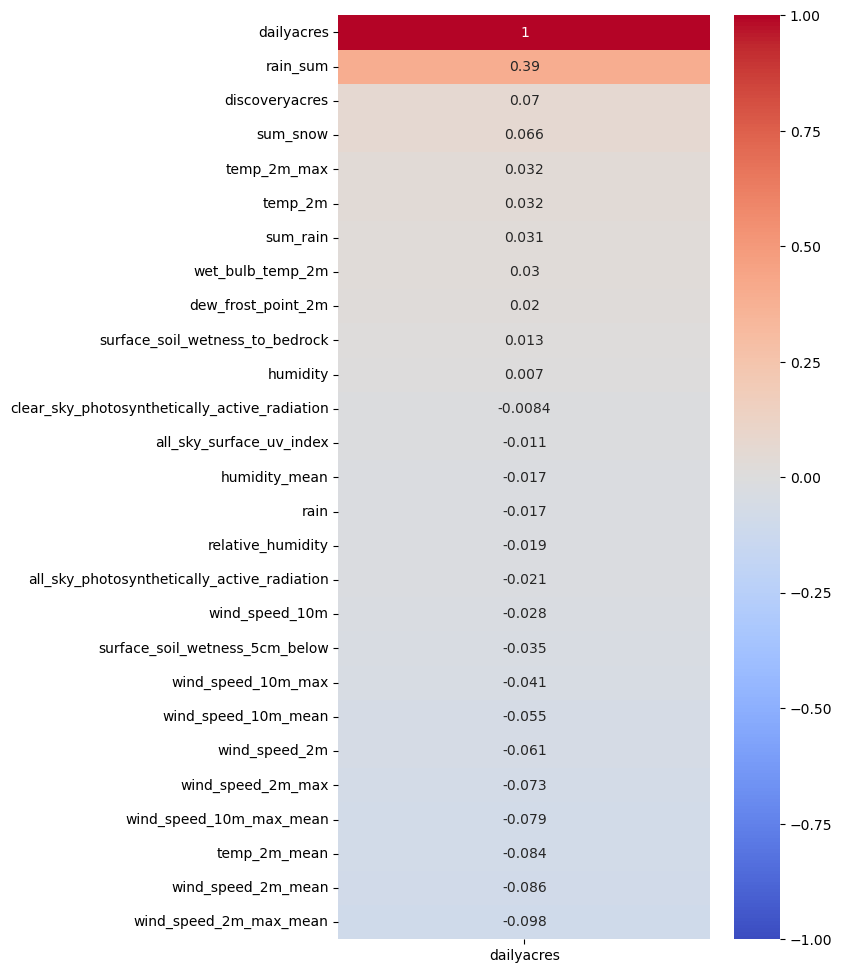

In [89]:
plt.figure(figsize = (6, 12))
sns.heatmap(df[cols].corr()[['dailyacres']].sort_values(by = 'dailyacres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

---
######
### Feature Selection, Train/Test Splitting Data, and Standard Scaling
######
___

In [90]:
df = df[cols]

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'dailyacres'), df['dailyacres'], random_state= 42)

In [91]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

---
######
### Using PCA For Feature Elimination
######
___

In [92]:
pca = PCA(random_state = 42)


Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

In [93]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:25], 3)

array([0.29 , 0.54 , 0.654, 0.729, 0.781, 0.819, 0.855, 0.885, 0.913,
       0.936, 0.956, 0.966, 0.973, 0.98 , 0.986, 0.99 , 0.994, 0.996,
       0.997, 0.998, 0.999, 0.999, 1.   , 1.   , 1.   ])

In [17]:
Z_train = Z_train[:,:20]
Z_test = Z_test[:,:20]

In [24]:
#np.savetxt('../../data/processed/Z_train_bigfires.csv', Z_train, delimiter=',')
#np.savetxt('../../data/processed/Z_test_bigfires.csv', Z_test, delimiter=',')
#np.savetxt('../../data/processed/y_train_bigfires.csv', y_train, delimiter=',')
#np.savetxt('../../data/processed/y_test_bigfires.csv', y_test, delimiter=',')

---
######
### Modeling / Simple Models
######
---

#### Linear Regression (Baseline) with DF

In [94]:
#Linear Regression - Baseline
# With X data
lr = LinearRegression()

lr.fit(X_train, y_train)
print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared = False)}')

Training R-Squared: 0.19715841710693816
Testing R-Squared: 0.1899752922589183
RMSE: 23227.40599818035


#### Linear Regression (Baseline) with PCA

In [95]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train, y_train)
print(f'Training R-Squared: {lr.score(Z_train, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test), squared = False)}')

Training R-Squared: 0.19715841710693816
Testing R-Squared: 0.18997529225891807
RMSE: 23227.405998180355


In [96]:
def model_eval(model, param_dict, training_data):
    '''
    d
    '''
    
    gs_model = GridSearchCV(model,
                            param_grid = param_dict,
                            n_jobs = -1)
    if training_data == 'X_train':
        gs_model.fit(X_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(X_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(X_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(X_test, y_test)}')
        
    elif training_data == 'Z_train':
        gs_model.fit(Z_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(Z_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(Z_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(Z_test, y_test)}')
    else:
        return 'Try Again'

In [28]:
#KNN Regressor with X Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train')

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.0009097   0.01663069 -0.00750554  0.01240767 -0.02440206  0.00560731
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan]
  warnings.warn(


Best Score: -0.0009096961525566494
Best Params: {'n_neighbors': 1000, 'weights': 'uniform'}
RMSE: 25693.100828635565
Training R-Squared: 0.009481649910421441
Testing R-Squared: 0.008871678554129736


In [29]:
#KNN Regressor with PCA Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train')

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.0009097   0.01663069 -0.00750554  0.01240767 -0.02440206  0.00560731
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan]
  warnings.warn(


Best Score: -0.0009096961525566494
Best Params: {'n_neighbors': 1000, 'weights': 'uniform'}
RMSE: 25693.100828635565
Training R-Squared: 0.009481649910421441
Testing R-Squared: 0.008871678554129736


In [97]:
# Lasso Regression with X Data

lasso = Lasso()
lasso_params = {
    'alpha': range(5, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train')

Best Score: -0.28621571171260163
Best Params: {'alpha': 99}
RMSE: 23171.54605524507
Training R-Squared: 0.1914979421750438
Testing R-Squared: 0.1938666889332521


In [98]:
# Lasso Regression with PCA Data

lasso = Lasso()
lasso_params = {
    'alpha': range(5, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train')

Best Score: -0.2861796521481802
Best Params: {'alpha': 99}
RMSE: 23193.142834828985
Training R-Squared: 0.1913179803960754
Testing R-Squared: 0.19236329362798255


In [99]:
# Adaboost with X Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train')

Best Score: -1.2742595839126174
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 24088.3023470683
Training R-Squared: 0.6058421970279164
Testing R-Squared: 0.12881732305497495


In [100]:
# Adaboost with PCA Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train')

Best Score: -1.9215994842876227
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 26031.90947726527
Training R-Squared: 0.6046281297591669
Testing R-Squared: -0.017440203732749904


In [56]:
# Random Forest with X_train

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'X_train')

Best Score: -0.2530594192656893
Best Params: {'ccp_alpha': 0.1, 'max_depth': 180, 'min_samples_leaf': 3, 'min_samples_split': 2}
RMSE: 16416.31340568967
Training R-Squared: 0.5854725752079336
Testing R-Squared: 0.20441180814714455


In [58]:
# Random Forest with PCA

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'Z_train')

Best Score: -0.29544449911795334
Best Params: {'ccp_alpha': 0.1, 'max_depth': 200, 'min_samples_leaf': 3, 'min_samples_split': 3}
RMSE: 15983.254054646812
Training R-Squared: 0.5698722617414869
Testing R-Squared: 0.24583310503806466


---

In [101]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -1.222260251021095
Testing R-Squared: -0.24911775864237606
RMSE: 28843.852728191017


In [102]:
# Stacking Regressor with Z_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -1.489835509404009
Testing R-Squared: -0.45687246798261594
RMSE: 31150.30807186376


In [48]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.2554078584323497
Testing R-Squared: 0.26153657482558923
RMSE: 15815.974842212936


In [42]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.09326870896544126
Testing R-Squared: 0.2940927886870889
RMSE: 15463.410305670468


In [49]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.08549472299369454
Testing R-Squared: 0.27806242995748676
RMSE: 15638.00299604798


In [50]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.04389292174951964
Testing R-Squared: 0.29462361544615145
RMSE: 15457.595139343894


In [51]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -0.09219904281525393
Testing R-Squared: 0.30355319635872857
RMSE: 15359.442240091097


In [52]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.19027240294668057
Testing R-Squared: 0.29703173721592424
RMSE: 15431.186829839435


In [53]:
#Voting Classifier with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(X_train, y_train)
print(f'Training R-Squared: {vote.score(X_train, y_train)}')
print(f'Testing R-Squared: {vote.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(X_test), squared = False)}')

Training R-Squared: 0.6616571452907578
Testing R-Squared: 0.0830865442231642
RMSE: 17623.641238516386


In [54]:
#Voting Classifier with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(Z_train, y_train)
print(f'Training R-Squared: {vote.score(Z_train, y_train)}')
print(f'Testing R-Squared: {vote.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(Z_test), squared = False)}')

Training R-Squared: 0.669675720288293
Testing R-Squared: 0.14713489908211408
RMSE: 16996.97525296164
